In [1]:
import os
import pandas as pd
import nltk
import warnings
warnings.filterwarnings("ignore")

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

base_dir = 'gutenberg_bookshelf_data'
genres = ["Fantasy", "Mystery_Fiction", "Science_Fiction", "Crime_Fiction", "Gothic_Fiction", "Horror", "Romantic_Fiction", "Detective_Fiction"]

books = []
for genre in genres:
    genre_path = os.path.join(base_dir, genre, "cleaned")  # Navigate to the 'cleaned' subdirectory
    for file_name in os.listdir(genre_path):
        if file_name.endswith(".txt"):  # Ensure it's a .txt file
            with open(os.path.join(genre_path, file_name), 'r', encoding='utf-8') as f:
                text = f.read()
                books.append({
                    'Title': file_name,
                    'Genre': genre,
                    'Text': text
                })
# Load your dataset (replace with your file path or structure)
# Example dataset structure: df = pd.DataFrame({'Title': ['Novel1', 'Novel2'], 'Text': ['Text1', 'Text2']})
df = pd.DataFrame(books)  # Replace 'novels.csv' with your dataset file

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\curti\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\curti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\curti\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
import numpy as np
import re
from textstat.textstat import textstat
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from textblob import TextBlob

# Make sure NLTK stopwords are downloaded
nltk.download('stopwords')
from nltk.corpus import stopwords

# Define stopwords
stop_words = set(stopwords.words('english'))

def extract_stylistic_features(texts):
    features = {
        'avg_sentence_length': [],
        'avg_word_length': [],
        'avg_syllables_per_word': [],
        'readability_score': [],
        'passive_voice_ratio': [],
        'type_token_ratio': [],
        'lexical_density': [],
        'sentence_complexity': [],
        'subordinate_clause_ratio': [],
        'exclamation_ratio': [],
        'sentiment_polarity': [],
        'sentiment_subjectivity': [],
        'dialogue_density': [],
    }
    
    for text in texts:
        # Basic feature extraction
        sentences = re.split(r'[.!?]', text)
        words = text.split()
        num_sentences = len(sentences)
        num_words = len(words)
        num_syllables = sum(textstat.syllable_count(word) for word in words)
        passive_voice = len(re.findall(r'\b(is|are|was|were|be|been|being)\s+\w+\s+\w+\b', text))  # very basic passive voice check
        
        # Add basic features
        features['avg_sentence_length'].append(num_words / num_sentences if num_sentences > 0 else 0)
        features['avg_word_length'].append(np.mean([len(word) for word in words]) if num_words > 0 else 0)
        features['avg_syllables_per_word'].append(num_syllables / num_words if num_words > 0 else 0)
        features['readability_score'].append(textstat.flesch_reading_ease(text))
        features['passive_voice_ratio'].append(passive_voice / num_sentences if num_sentences > 0 else 0)

        # Type-Token Ratio (TTR)
        type_token_ratio = len(set(words)) / len(words) if len(words) > 0 else 0
        features['type_token_ratio'].append(type_token_ratio)
        
        # Lexical Density (using stopwords from nltk)
        lexical_density = len([word for word in words if word.lower() not in stop_words]) / len(words) if len(words) > 0 else 0
        features['lexical_density'].append(lexical_density)

        # Sentence Complexity (average number of clauses per sentence)
        sentence_complexity = sum([len(re.findall(r'\w+', sentence)) > 1 for sentence in sentences]) / num_sentences if num_sentences > 0 else 0
        features['sentence_complexity'].append(sentence_complexity)

        # Subordinate Clause Ratio
        subordinate_clause_ratio = len(re.findall(r'\b(although|because|if|when|while|where|since|as)\b', text)) / num_sentences if num_sentences > 0 else 0
        features['subordinate_clause_ratio'].append(subordinate_clause_ratio)

        # Exclamation Ratio
        exclamation_ratio = text.count('!') / num_sentences if num_sentences > 0 else 0
        features['exclamation_ratio'].append(exclamation_ratio)

        # Sentiment Polarity and Subjectivity (using TextBlob)
        blob = TextBlob(text)
        features['sentiment_polarity'].append(blob.sentiment.polarity)
        features['sentiment_subjectivity'].append(blob.sentiment.subjectivity)
        
        # Dialogue Density (basic check for quotes)
        dialogue_density = text.count('"') / num_sentences if num_sentences > 0 else 0
        features['dialogue_density'].append(dialogue_density)
    
    return features


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\curti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


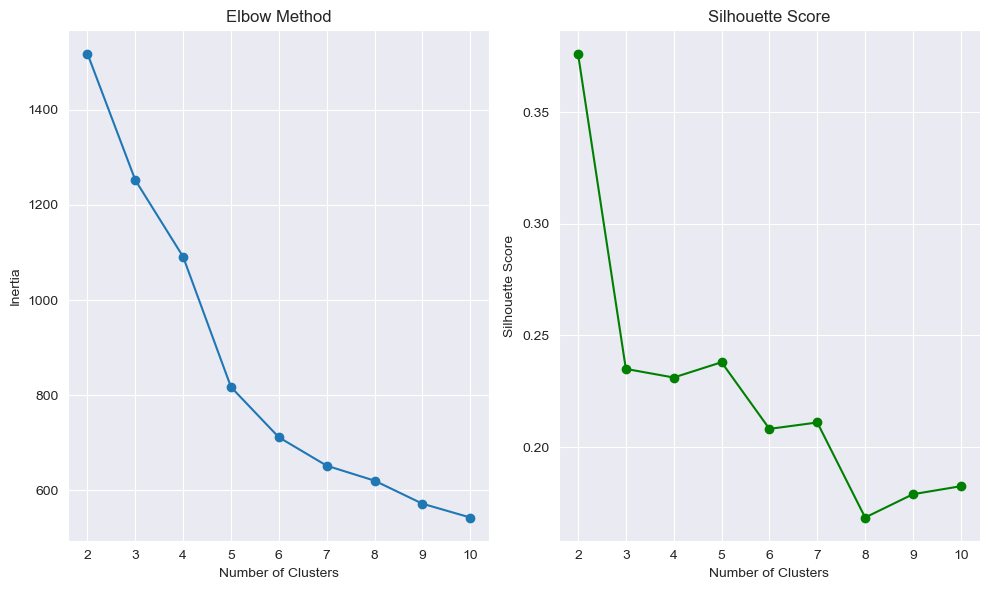

Optimal number of clusters based on Elbow Method: 5
Optimal number of clusters based on Silhouette Score: 2


In [3]:
# Load your dataset (df created from the previous code)
# df is already populated with Title, Genre, and Text columns

# Extract stylistic features from the 'Text' column
stylistic_features = extract_stylistic_features(df['Text'])

# Convert the features into a DataFrame for easier manipulation
stylistic_features_df = pd.DataFrame(stylistic_features)

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(stylistic_features_df)

# Elbow Method for Optimal Clusters
inertia = []
silhouette_avg = []

# Try different values for k (clusters)
range_n_clusters = list(range(2, 11))  # Try clustering with 2 to 10 clusters
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)
    # Calculate the silhouette score for this k
    silhouette_avg.append(silhouette_score(scaled_features, kmeans.labels_))

# Plot the Elbow Method
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(range_n_clusters, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

# Plot the Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(range_n_clusters, silhouette_avg, marker='o', color='green')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

# Select the best number of clusters based on both methods
# Based on the elbow method, choose the k where inertia stops decreasing significantly
optimal_clusters_inertia = range_n_clusters[np.argmin(np.diff(inertia)) + 1]
# Based on silhouette score, choose the k with the highest score
optimal_clusters_silhouette = range_n_clusters[np.argmax(silhouette_avg)]

print(f"Optimal number of clusters based on Elbow Method: {optimal_clusters_inertia}")
print(f"Optimal number of clusters based on Silhouette Score: {optimal_clusters_silhouette}")

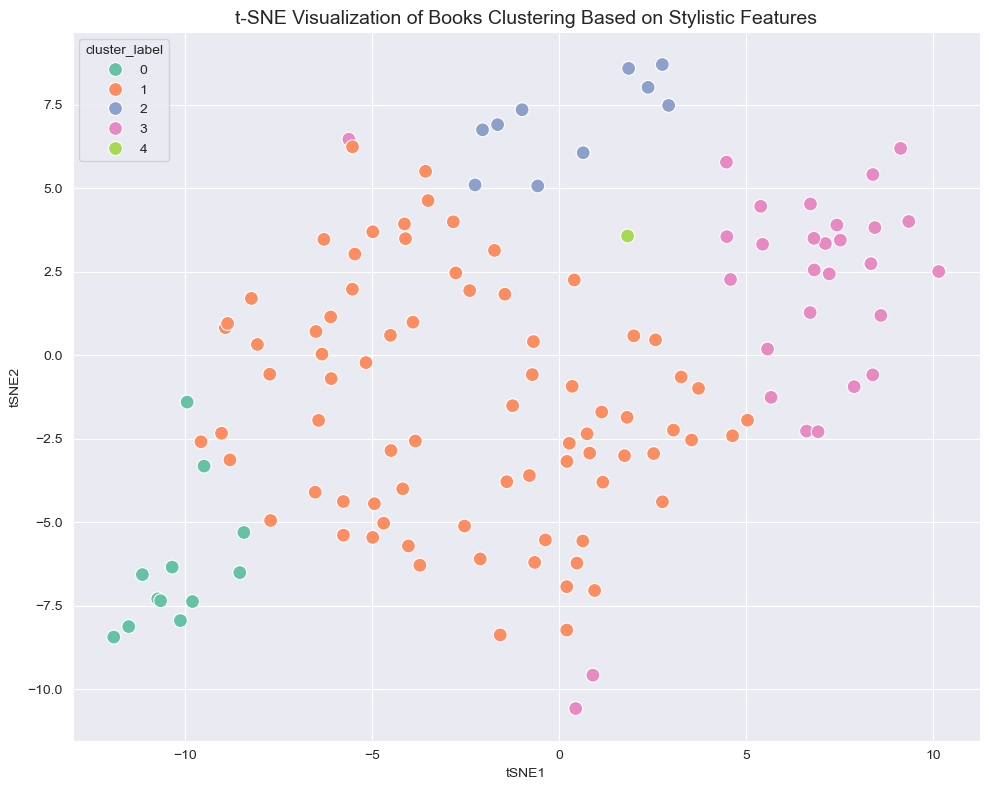

                                                 Title              Genre  \
0       Dorothy and the Wizard in Oz L. Frank Baum.txt            Fantasy   
1    Four Arthurian Romances active 12th century de...            Fantasy   
2                 Irish Fairy Tales James Stephens.txt            Fantasy   
3    Le Morte d'Arthur_ Volume 1 Sir Thomas Malory.txt            Fantasy   
4    Le Morte d'Arthur_ Volume 2 Sir Thomas Malory.txt            Fantasy   
..                                                 ...                ...   
134           The Secret Adversary Agatha Christie.txt  Detective_Fiction   
135        The Sign of the Four Arthur Conan Doyle.txt  Detective_Fiction   
136    The wisdom of Father Brown G. K. Chesterton.txt  Detective_Fiction   
137  The Works of Edgar Allan Poe — Volume 2 Edgar ...  Detective_Fiction   
138  Whose Body_ A Lord Peter Wimsey Novel Dorothy ...  Detective_Fiction   

     cluster_label  
0                1  
1                2  
2           

In [4]:
# Choose the optimal number of clusters (you can select one of the above values based on the methods)
optimal_clusters = 5  # Use silhouette score optimal clusters here

# Apply K-Means with the chosen number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans.fit(scaled_features)

# Add cluster labels to the original DataFrame
df['cluster_label'] = kmeans.labels_

# Visualize the clustering using t-SNE (to reduce to 2D)
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(scaled_features)

# Create a DataFrame with t-SNE results and cluster labels
tsne_df = pd.DataFrame(tsne_results, columns=['tSNE1', 'tSNE2'])
tsne_df['cluster_label'] = kmeans.labels_
df['cluster'] = kmeans.labels_

# Plot the t-SNE results
plt.figure(figsize=(10, 8))
sns.scatterplot(x='tSNE1', y='tSNE2', hue='cluster_label', palette='Set2', data=tsne_df, s=100, marker="o")
plt.title('t-SNE Visualization of Books Clustering Based on Stylistic Features', fontsize=14)
plt.tight_layout()
plt.show()

# Print the cluster assignments
print(df[['Title', 'Genre', 'cluster_label']])

<Figure size 1000x600 with 0 Axes>

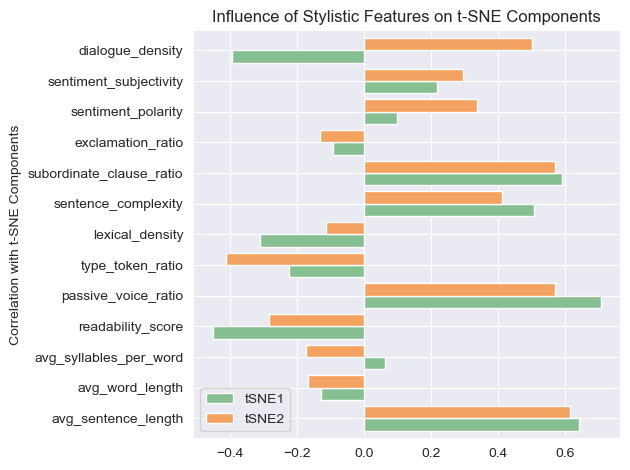

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming `tsne_results` contains the 2D t-SNE projection and `df_features` contains the stylistic features
# Example: tsne_results[:, 0] and tsne_results[:, 1] are the first and second t-SNE components
tsne_df = pd.DataFrame(tsne_results, columns=['tSNE1', 'tSNE2'])

# Combine t-SNE components with the stylistic features into a single dataframe
df_combined = pd.concat([stylistic_features_df, tsne_df], axis=1)

# Calculate correlations between t-SNE components and stylistic features
correlation_matrix = df_combined.corr()

# Extract the correlations with tSNE components
tsne_correlations = correlation_matrix[['tSNE1', 'tSNE2']]

# Plot the correlations for both tSNE components
plt.figure(figsize=(10, 6))
tsne_correlations.drop(['tSNE1', 'tSNE2'], axis=0).plot(kind='barh', color=['#86bf91', '#f4a261'], width=0.8)
plt.title("Influence of Stylistic Features on t-SNE Components")
plt.ylabel("Correlation with t-SNE Components")
plt.tight_layout()
plt.legend(['tSNE1', 'tSNE2'])
plt.show()

In [6]:
# Group by cluster and genre, then count the number of books in each genre per cluster
genre_count_per_cluster = df.groupby(['cluster_label', 'Genre']).size().unstack(fill_value=0)

# Display the results
genre_count_per_cluster


Genre,Crime_Fiction,Detective_Fiction,Fantasy,Gothic_Fiction,Horror,Mystery_Fiction,Romantic_Fiction,Science_Fiction
cluster_label,,,,,,,,
0,3,1,0,1,1,0,0,6
1,19,16,6,8,9,8,4,11
2,0,0,11,0,0,0,0,0
3,0,1,3,12,9,5,1,3
4,0,0,0,0,0,0,1,0


In [7]:
from sklearn.cluster import AgglomerativeClustering
import pandas as pd

# Assuming df_features contains the stylistic features for each book
agg_clust = AgglomerativeClustering(n_clusters=5)  # You can adjust the number of clusters
df['Agglomerative_Cluster'] = agg_clust.fit_predict(stylistic_features_df)
tsne_df['agg_cluster'] = agg_clust.labels_

# Inspect the clusters
print(df[['Title', 'Agglomerative_Cluster']])


                                                 Title  Agglomerative_Cluster
0       Dorothy and the Wizard in Oz L. Frank Baum.txt                      1
1    Four Arthurian Romances active 12th century de...                      3
2                 Irish Fairy Tales James Stephens.txt                      3
3    Le Morte d'Arthur_ Volume 1 Sir Thomas Malory.txt                      1
4    Le Morte d'Arthur_ Volume 2 Sir Thomas Malory.txt                      1
..                                                 ...                    ...
134           The Secret Adversary Agatha Christie.txt                      3
135        The Sign of the Four Arthur Conan Doyle.txt                      1
136    The wisdom of Father Brown G. K. Chesterton.txt                      1
137  The Works of Edgar Allan Poe — Volume 2 Edgar ...                      0
138  Whose Body_ A Lord Peter Wimsey Novel Dorothy ...                      3

[139 rows x 2 columns]


In [8]:
from sklearn.metrics import silhouette_score

# Evaluate the clustering with silhouette score
sil_score = silhouette_score(stylistic_features_df, df['cluster_label'])
print(f"Silhouette Score: {sil_score}")


Silhouette Score: 0.3228411652204367


In [9]:
from sklearn.metrics import silhouette_score

# Evaluate the clustering with silhouette score
sil_score = silhouette_score(stylistic_features_df, df['Agglomerative_Cluster'])
print(f"Silhouette Score: {sil_score}")


Silhouette Score: 0.4028292665527601


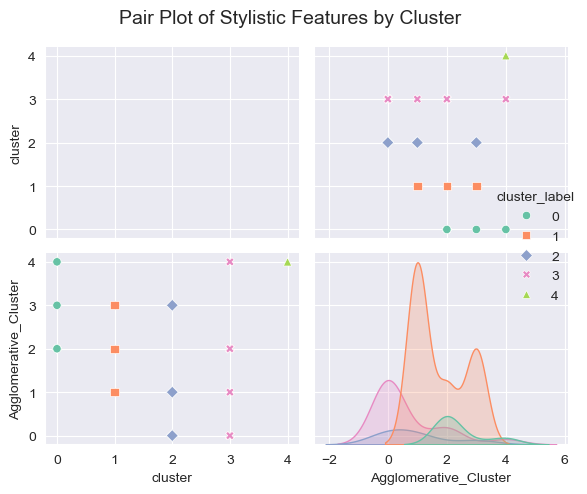

In [10]:
# Create a pair plot for the stylistic features (without cluster labels)
sns.pairplot(df, hue='cluster_label', palette='Set2', markers=["o", "s", "D", "X", "^"])

# Title and show the plot
plt.suptitle('Pair Plot of Stylistic Features by Cluster', fontsize=14)
plt.tight_layout()
plt.show()

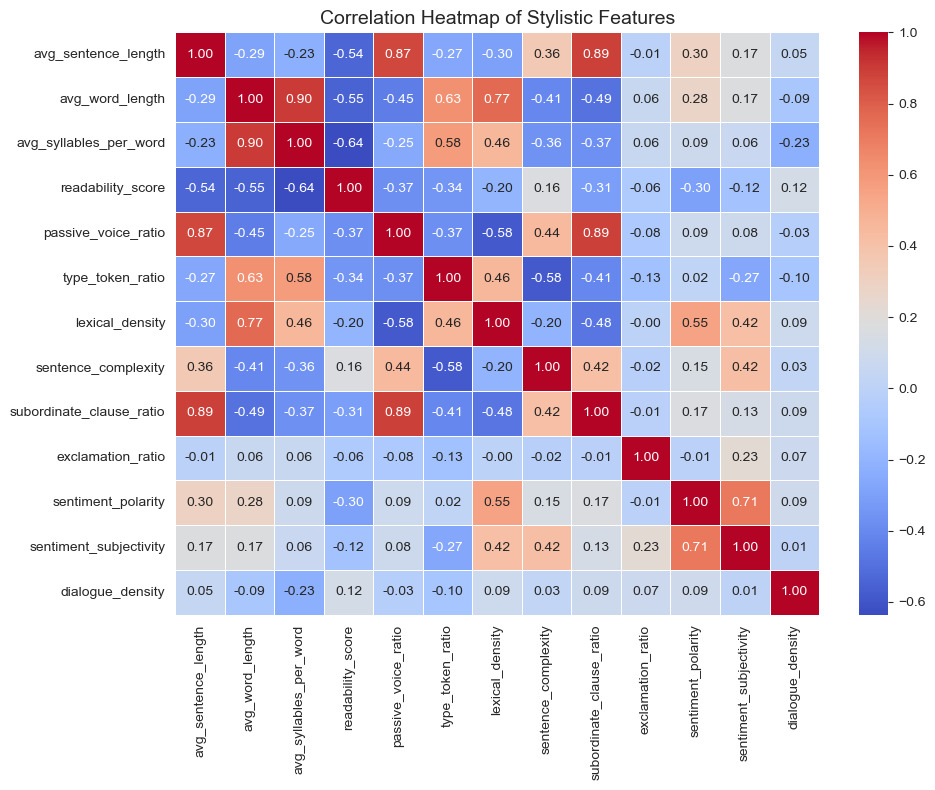

In [11]:
# Calculate the correlation matrix of stylistic features
corr_matrix = stylistic_features_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar=True)
plt.title('Correlation Heatmap of Stylistic Features', fontsize=14)
plt.tight_layout()
plt.show()


In [12]:
# Set a correlation threshold (e.g., 0.9)
threshold = 0.7

# Create a list to hold columns to drop
to_drop = []

# Iterate over the correlation matrix
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:  # If correlation exceeds threshold
            colname = correlation_matrix.columns[i]
            to_drop.append(colname)

# Drop the features
df_reduced = stylistic_features_df.drop(columns=to_drop)

# Show reduced dataset
print("Columns dropped:", to_drop)
print("\nReduced dataframe:")
print(df_reduced)


KeyError: "['tSNE1'] not found in axis"

In [ ]:
df

In [ ]:
# Plot the t-SNE results
plt.figure(figsize=(10, 8))
sns.scatterplot(x='tSNE1', y='tSNE2', hue='agg_cluster', palette='Set2', data=tsne_df, s=100, marker="o")
plt.title('t-SNE Visualization of Books Clustering Based on Stylistic Features', fontsize=14)
plt.tight_layout()
plt.show()

# Print the cluster assignments
print(df[['Title', 'Genre', 'cluster_label']])

In [ ]:
tsne_df

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import seaborn as sns
import matplotlib.pyplot as plt

# Standardize the features (important for DBSCAN)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(stylistic_features_df)

# Apply DBSCAN with chosen parameters
dbscan = DBSCAN(eps=1, min_samples=2)
labels = dbscan.fit_predict(scaled_features)

# Add the labels to the original dataframe
stylistic_features_df['Cluster'] = labels

# Visualize the clusters (2D visualization for simplicity, you can choose any 2 features for this plot)
plt.figure(figsize=(8, 6))
sns.scatterplot(x='avg_sentence_length', y='avg_word_length', hue='Cluster', data=stylistic_features_df, palette='viridis')
plt.title("DBSCAN Clustering")
plt.show()

# Print the cluster assignments for each book
print(df[['avg_sentence_length', 'avg_word_length', 'avg_syllables_per_word', 'readability_score', 'passive_voice_ratio', 'Cluster']])


In [ ]:
/from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Find the k-distance (k=min_samples) for each point
neighbors = NearestNeighbors(n_neighbors=2)
neighbors_fit = neighbors.fit(scaled_features)
distances, indices = neighbors_fit.kneighbors(scaled_features)

# Sort and plot the distances to the second nearest neighbor (k=2)
distances = np.sort(distances[:, 1], axis=0)
plt.plot(distances)
plt.title("K-distance Plot")
plt.xlabel("Points")
plt.ylabel("Distance to 2nd Nearest Neighbor")
plt.show()


In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(stylistic_features_df)

# Parameters to test
eps_values = np.linspace(0.1, 5, 50)
min_samples_values = [3, 4, 5, 6, 7]

# Grid search for best eps and min_samples
best_score = -1
best_eps = 0
best_min_samples = 0
best_labels = None

for eps in eps_values:
    for min_samples in min_samples_values:
        # Apply DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_scaled)
        
        # Calculate silhouette score (exclude noise points labeled as -1)
        if len(set(labels)) > 1:  # Ensure there are at least 2 clusters
            score = silhouette_score(X_scaled, labels)
            if score > best_score:
                best_score = score
                best_eps = eps
                best_min_samples = min_samples
                best_labels = labels

print(f"Best eps: {best_eps}, Best min_samples: {best_min_samples}, Best silhouette score: {best_score}")

# Apply the best DBSCAN model
dbscan_best = DBSCAN(eps=best_eps, min_samples=best_min_samples)
labels_best = dbscan_best.fit_predict(X_scaled)

# Add cluster labels to the dataframe
df['Cluster'] = labels_best

# Plot the results of DBSCAN clustering (2D projection using PCA)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_best, cmap='viridis', s=50)
plt.title(f"DBSCAN Clustering (eps={best_eps}, min_samples={best_min_samples})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Cluster')
plt.show()


In [ ]:
# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plotting the DBSCAN results after PCA
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_best, cmap='viridis', s=50)
plt.title(f"DBSCAN Clustering (eps={best_eps}, min_samples={best_min_samples}) using PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Cluster')
plt.show()


In [ ]:
# t-SNE for visualization
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Plotting the DBSCAN results after t-SNE
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels_best, cmap='viridis', s=50)
plt.title(f"DBSCAN Clustering (eps={best_eps}, min_samples={best_min_samples}) using t-SNE")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.colorbar(label='Cluster')
plt.show()


In [ ]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Compute k-distance plot (using k=4 for min_samples)
knn = NearestNeighbors(n_neighbors=4)
knn.fit(X_scaled)
distances, indices = knn.kneighbors(X_scaled)

# Sort distances and plot
distances = np.sort(distances[:, -1], axis=0)
plt.plot(distances)
plt.title('K-distance Plot')
plt.xlabel('Data Points Sorted by Distance')
plt.ylabel('Distance to 4th Nearest Neighbor')
plt.show()


In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Fine-tuning DBSCAN with different eps and min_samples
eps_values = [0.5, 1, 1.5, 2, 2.5, 3]
min_samples_values = [3, 4, 5, 6]

best_score = -1
best_labels = None
best_eps = 0
best_min_samples = 0

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_scaled)
        
        # Only compute silhouette score if there are at least 2 clusters
        if len(set(labels)) > 1:  # Avoid single-cluster case
            score = silhouette_score(X_scaled, labels)
            if score > best_score:
                best_score = score
                best_eps = eps
                best_min_samples = min_samples
                best_labels = labels

print(f"Best eps: {best_eps}, Best min_samples: {best_min_samples}, Best silhouette score: {best_score}")

# Apply the best DBSCAN model
dbscan_best = DBSCAN(eps=best_eps, min_samples=best_min_samples)
labels_best = dbscan_best.fit_predict(X_scaled)

# Add cluster labels to the dataframe
df['Cluster'] = labels_best


In [ ]:
# Use PCA for visualization
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_best, cmap='viridis', s=50)
plt.title(f"DBSCAN Clustering Results (eps={best_eps}, min_samples={best_min_samples})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Cluster')
plt.show()


In [ ]:
# Count the number of books in each cluster
print(df['Cluster'].value_counts())


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(stylistic_features_df)

# Apply t-SNE for 2D visualization
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Plot t-SNE result
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.7, edgecolors='k')
plt.title('t-SNE of Stylistic Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Fine-tuning DBSCAN with different eps and min_samples
eps_values = [0.5, 1, 1.5, 2, 2.5, 3]
min_samples_values = [3, 4, 5, 6]

best_score = -1
best_labels = None
best_eps = 0
best_min_samples = 0

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_scaled)
        
        # Only compute silhouette score if there are at least 2 clusters
        if len(set(labels)) > 1:  # Avoid single-cluster case
            score = silhouette_score(X_scaled, labels)
            if score > best_score:
                best_score = score
                best_eps = eps
                best_min_samples = min_samples
                best_labels = labels

print(f"Best eps: {best_eps}, Best min_samples: {best_min_samples}, Best silhouette score: {best_score}")

# Apply the best DBSCAN model
dbscan_best = DBSCAN(eps=best_eps, min_samples=best_min_samples)
labels_best = dbscan_best.fit_predict(X_scaled)

# Add cluster labels to the dataframe
df['Cluster'] = labels_best


In [ ]:
# Apply t-SNE again for 2D visualization, now with DBSCAN labels
X_tsne = tsne.fit_transform(X_scaled)

# Plot t-SNE result with DBSCAN cluster colors
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df['Cluster'], cmap='viridis', alpha=0.7, edgecolors='k')
plt.title(f"DBSCAN Clustering Results (eps={best_eps}, min_samples={best_min_samples})")
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
plt.show()
